# Training and testing dataset generation using LeR

* `ler` package is used to generate training and testing datasets.

* It assumes theoretically or observationally available astrophysical models.

* Input parameters for ANN needs all the intrinsic and extrinsic parameters of the source.

* Output parameters are the net optimal SNR of the given network of data.

* The dataset is tuned to accumulated more points between the SNR range 2-16; with the assumption that SNR threshold cut for detection around 8.

* The dataset is generated for the network of 3 detectors, namely, LIGO Hanford, LIGO Livingston, and Virgo.

* Waveform model used is IMRPhenomXPHM with spin and precession effects.

* ANN needs at-least 100000 samples for training and testing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import contextlib
from ler.rates import LeR
from gwsnr import GWSNR
from ler.utils import append_json, get_param_from_json

Setting multiprocessing start method to 'fork'


## Initialization

In [2]:
# find out the redshift of detector horizon
gwsnr = GWSNR(
    npool=6,
    waveform_approximant='IMRPhenomXPHM',
    snr_type='inner_product',
)

psds not given. Choosing bilby's default psds
Intel processor has trouble allocating memory when the data is huge. So, by default for IMRPhenomXPHM, duration_max = 64.0. Otherwise, set to some max value like duration_max = 600.0 (10 mins)

Chosen GWSNR initialization parameters:

npool:  6
snr type:  inner_product
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/

In [5]:
size = 1000
mtot = 184.9*np.ones(1000) 
q = np.linspace(0.1,1,1000)
mass_1 = mtot / (1+q)
mass_2 = mtot-mass_1

horizons = gwsnr.detector_horizon(
    mass_1=mass_1,
    mass_2=mass_2,
    snr_th=8,
    snr_th_net=8,
);
horizons.keys()

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 406.18it/s]


dict_keys(['L1', 'H1', 'V1', 'net'])

In [13]:
# initialize the LeR class
ler = LeR(
    npool=6,
    z_max=10,  # becareful with this value
    spin_zero=False,
    spin_precession=True,
    waveform_approximant='IMRPhenomXPHM',
    snr_type='inner_product',
    verbose=False,
)

In [14]:
zs = ler.luminosity_distance_to_z(horizons['net'])
print(f'max redshift = {max(zs)}')

max redshift = 4.562955379405955


In [38]:
# re-initialize the LeR class with the new max redshift
# I will choose a value a liitle bit higher than max(zs)

# # Uncomment the following if you want to use the  IMRPhenomXPHM with inner product
# ler = LeR(
#     npool=6,
#     z_max=5,  # becareful with this value
#     spin_zero=False,
#     spin_precession=True,
#     waveform_approximant='IMRPhenomXPHM',
#     snr_type='inner_product',
#     verbose=False,
# )

# First I will use the fastest SNR calculator with IMRPhenomD
# I will pick parameter points within certain SNR range
# For these collected point will recalculate SNR with IMRPhenomXPHM
ler = LeR(
    npool=6,
    z_max=5,  # becareful with this value
    spin_zero=False,
    spin_precession=True,
    waveform_approximant='IMRPhenomD',
    snr_type='interpolation',
    verbose=False,
)

## Collection of data at the desired SNR range

* The idea is, you need more data points in the parameter space where you want the ANN to be more sensitive.

In [ ]:
class ModelGenerator(
    
)

In [40]:
# uncomment the following line to generate the data

## This is data collection based of each detector SNR range. Later I will generate the data based on combined net SNR.
ler.batch_size = 200000

len_ = 0
size = 1000
while len_<size:
    with contextlib.redirect_stdout(None):
        unlensed_param = ler.unlensed_cbc_statistics(size=ler.batch_size, resume=False)

    # SNR for each detector
    detectors = ["L1", "H1", "V1"]
    for i,det in enumerate(detectors):
        snr = np.array(unlensed_param[det])

        # setting SNR range
        idx1 = np.argwhere(snr<2).flatten()
        idx2 = np.argwhere((snr>=2) & (snr<4)).flatten()
        idx3 = np.argwhere((snr>=4) & (snr<6)).flatten()
        idx4 = np.argwhere((snr>=6) & (snr<8)).flatten()
        idx5 = np.argwhere((snr>=8) & (snr<10)).flatten()
        idx6 = np.argwhere((snr>=10) & (snr<12)).flatten()
        idx7 = np.argwhere((snr>=12) & (snr<14)).flatten()
        idx8 = np.argwhere((snr>=14) & (snr<16)).flatten()
        idx16 = np.argwhere(snr>=16).flatten()

        unlensed_param1 = {}
        unlensed_param2 = {}
        unlensed_param3 = {}
        unlensed_param4 = {}
        unlensed_param5 = {}
        unlensed_param6 = {}
        unlensed_param7 = {}
        unlensed_param8 = {}
        unlensed_param16 = {}
        len_idx16 = len(idx16)

        for key, value in unlensed_param.items():
            if len(idx1)>len_idx16:
                unlensed_param1[key] = value[idx1][:len_idx16]
            else:
                unlensed_param1[key] = value[idx1]
            if len(idx2)>len_idx16:
                unlensed_param2[key] = value[idx2][:len_idx16]
            else:
                unlensed_param2[key] = value[idx2]
            if len(idx3)>len_idx16:
                unlensed_param3[key] = value[idx3][:len_idx16]
            else:
                unlensed_param3[key] = value[idx3]
            if len(idx4)>len_idx16:
                unlensed_param4[key] = value[idx4][:len_idx16]
            else:
                unlensed_param4[key] = value[idx4]
            if len(idx5)>len_idx16:
                unlensed_param5[key] = value[idx5][:len_idx16]
            else:
                unlensed_param5[key] = value[idx5]
            if len(idx6)>len_idx16:
                unlensed_param6[key] = value[idx6][:len_idx16]
            else:
                unlensed_param6[key] = value[idx6]
            if len(idx7)>len_idx16:
                unlensed_param7[key] = value[idx7][:len_idx16]
            else:
                unlensed_param7[key] = value[idx7]
            if len(idx8)>len_idx16:
                unlensed_param8[key] = value[idx8][:len_idx16]
            else:
                unlensed_param8[key] = value[idx8]
            unlensed_param16[key] = value[idx16]
            
            unlensed_param[key] = np.concatenate([unlensed_param1[key], unlensed_param2[key], unlensed_param3[key], unlensed_param4[key], unlensed_param5[key], unlensed_param6[key], unlensed_param7[key], unlensed_param8[key], unlensed_param16[key]])

        # save the parameters
        append_json(ler.ler_directory+"/snr_"+det+"_IMRPhenomD.json", unlensed_param, replace=False);

    unlensed_params = get_param_from_json(ler.ler_directory+"/snr_"+det+"_IMRPhenomD.json")
    len_ = len(unlensed_params[det])

    print(f"Collected number of events: {len_}")

Collected number of events: 109
Collected number of events: 182
Collected number of events: 249
Collected number of events: 321
Collected number of events: 394
Collected number of events: 507
Collected number of events: 589
Collected number of events: 708
Collected number of events: 743
Collected number of events: 822
Collected number of events: 897
Collected number of events: 987
Collected number of events: 1028


In [47]:
# get spin
unlensed_params = get_param_from_json(ler.ler_directory+"/snr_"+det+"_IMRPhenomD.json")
size = len(unlensed_params['optimal_snr_net'])
a_1 = ler.sample_a_1(size)
a_2 = ler.sample_a_2(size)
phi_12 = ler.sample_phi_12
phi_jl = ler.sample_phi_jl
tilt_1 = ler.sample_tilt_1
tilt_2 = ler.sample_tilt_2

unlensed_params

In [49]:
a_1

array([0.72855951, 0.79310741, 0.18454806, ..., 0.36760531, 0.65000473,
       0.44887412])

In [41]:
gwsnr = GWSNR(
    npool=6,
)

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_0.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_0.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_3.pickle

Chosen GWSNR initialization parameters:

npool:  6
snr type:  interpolation
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_

In [42]:
newsnr = gwsnr.snr(gw_param_dict=unlensed_params)

(array([  0.,   0.,   0.,   0.,   0., 130.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

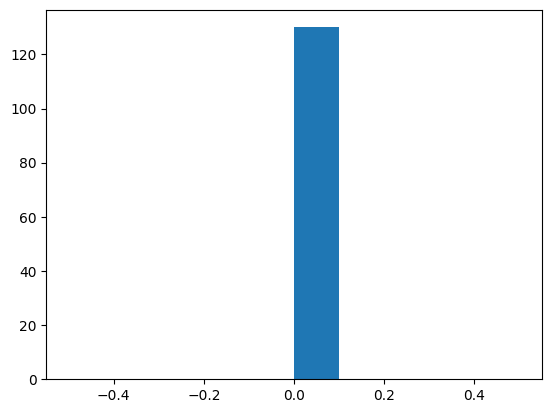

In [43]:
idx = (unlensed_params['optimal_snr_net']>6) & (unlensed_params['optimal_snr_net']<10) 
plt.hist(unlensed_params['optimal_snr_net'][idx]-newsnr['optimal_snr_net'][idx])

In [2]:
# ## This is data collection based of 'optimal snr net' range
# ler.batch_size = 100000

# len_ = 0
# while len_<100000:
#     with contextlib.redirect_stdout(None):
#         unlensed_param = ler.unlensed_cbc_statistics(size=100000, resume=False)
#     snr = np.sqrt(unlensed_param["L1"]**2 + unlensed_param["H1"]**2 + unlensed_param["V1"]**2)

#     idx = np.argwhere(snr>12).flatten()

#     unlensed_param_joint = {}

#     len_idx = len(idx)

#     for key, value in unlensed_param.items():
#         unlensed_param_joint[key] = value[idx]

#     append_json("joint_optsnr.json", unlensed_param_joint, replace=False)
#     unlensed_params = load_json("joint_optsnr.json")
#     len_ = len(np.array(unlensed_params["optimal_snr_net"]))

#     print(f"Number of events: {len_}")

In [3]:
# uncomment the following line to generate the data

# This is data collection based of 'optimal snr net' range
 
ler.batch_size = 10000

len_ = 0
while len_<100000:
    with contextlib.redirect_stdout(None):
        unlensed_param = ler.unlensed_cbc_statistics(size=ler.batch_size, resume=False)
    snr = np.sqrt(unlensed_param["L1"]**2 + unlensed_param["H1"]**2 + unlensed_param["V1"]**2)

    idx1 = np.argwhere(snr<2).flatten()
    idx2 = np.argwhere((snr>=2) & (snr<4)).flatten()
    idx3 = np.argwhere((snr>=4) & (snr<6)).flatten()
    idx4 = np.argwhere((snr>=6) & (snr<8)).flatten()
    idx5 = np.argwhere((snr>=8) & (snr<10)).flatten()
    idx6 = np.argwhere((snr>=10) & (snr<12)).flatten()
    idx7 = np.argwhere((snr>=12) & (snr<14)).flatten()
    idx8 = np.argwhere((snr>=14) & (snr<16)).flatten()
    idx16 = np.argwhere(snr>=16).flatten()

    unlensed_param1 = {}
    unlensed_param2 = {}
    unlensed_param3 = {}
    unlensed_param4 = {}
    unlensed_param5 = {}
    unlensed_param6 = {}
    unlensed_param7 = {}
    unlensed_param8 = {}
    unlensed_param16 = {}
    unlensed_param_joint = {}

    len_idx16 = len(idx16)

    for key, value in unlensed_param.items():
        if len(idx1)>len_idx16:
            unlensed_param1[key] = value[idx1][:len_idx16]
        else:
            unlensed_param1[key] = value[idx1]
        if len(idx2)>len_idx16:
            unlensed_param2[key] = value[idx2][:len_idx16]
        else:
            unlensed_param2[key] = value[idx2]
        if len(idx3)>len_idx16:
            unlensed_param3[key] = value[idx3][:len_idx16]
        else:
            unlensed_param3[key] = value[idx3]
        if len(idx4)>len_idx16:
            unlensed_param4[key] = value[idx4][:len_idx16]
        else:
            unlensed_param4[key] = value[idx4]
        if len(idx5)>len_idx16:
            unlensed_param5[key] = value[idx5][:len_idx16]
        else:
            unlensed_param5[key] = value[idx5]
        if len(idx6)>len_idx16:
            unlensed_param6[key] = value[idx6][:len_idx16]
        else:
            unlensed_param6[key] = value[idx6]
        if len(idx7)>len_idx16:
            unlensed_param7[key] = value[idx7][:len_idx16]
        else:
            unlensed_param7[key] = value[idx7]
        if len(idx8)>len_idx16:
            unlensed_param8[key] = value[idx8][:len_idx16]
        else:
            unlensed_param8[key] = value[idx8]
        unlensed_param16[key] = value[idx16]
        unlensed_param_joint[key] = np.concatenate([unlensed_param1[key], unlensed_param2[key], unlensed_param3[key], unlensed_param4[key], unlensed_param5[key], unlensed_param6[key], unlensed_param7[key], unlensed_param8[key], unlensed_param16[key]])

    append_json("joint_new_optsnr.json", unlensed_param_joint, replace=False)
    unlensed_params = load_json("joint_new_optsnr.json")
    len_ = len(np.array(unlensed_params["optimal_snr_net"]))

    print(f"collected number of events: {len_}")

In [6]:
# getting data
unlensed_params = get_param_from_json("joint_new_optsnr.json")

In [7]:
# checking the keys
unlensed_params.keys()

dict_keys(['zs', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'L1', 'H1', 'V1', 'optimal_snr_net'])

In [8]:
# checking the length of the data
len(np.array(unlensed_params["optimal_snr_net"]))

100007

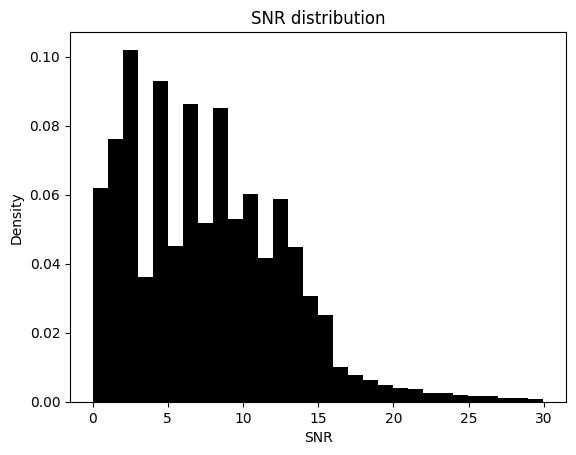

In [9]:
# plotting the SNR distribution (net)
test = np.array(unlensed_params["optimal_snr_net"])
test = test[test<30]
plt.hist(test, bins=30, color='k', density=True)
plt.xlabel("SNR")
plt.ylabel("Density")
plt.title("SNR distribution")
#plt.xlim(0, 100)
plt.show()


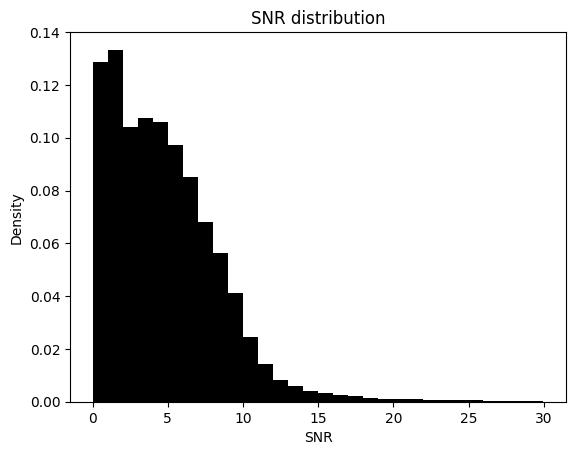

In [10]:
# plotting the SNR distribution (L1 detector)
test = np.array(unlensed_params["L1"])
test = test[test<30]
plt.hist(test, bins=30, color='k', density=True)
plt.xlabel("SNR")
plt.ylabel("Density")
plt.title("SNR distribution")
#plt.xlim(0, 100)
plt.show()

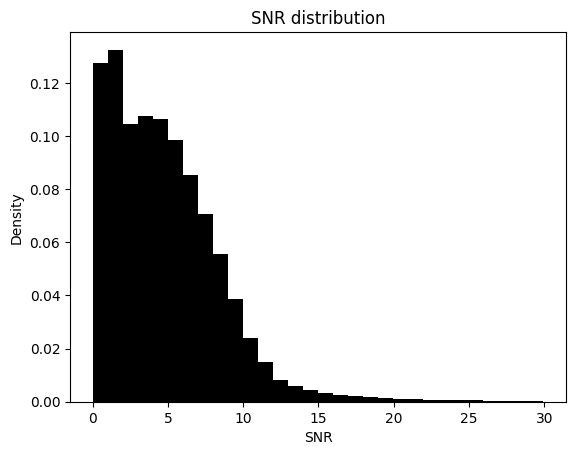

In [11]:
# plotting the SNR distribution (H1 detector)
test = np.array(unlensed_params["H1"])
test = test[test<30]
plt.hist(test, bins=30, color='k', density=True)
plt.xlabel("SNR")
plt.ylabel("Density")
plt.title("SNR distribution")
#plt.xlim(0, 100)
plt.show()

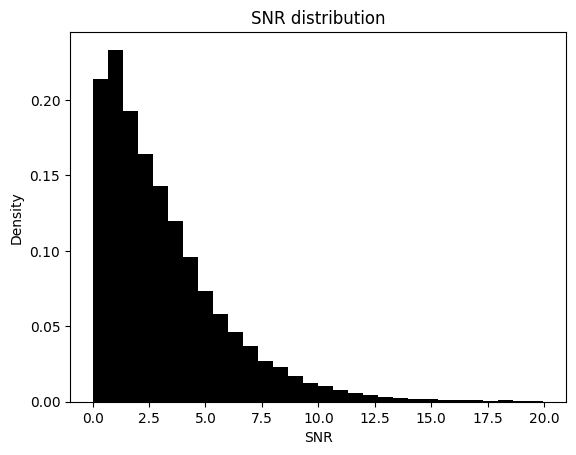

In [12]:
# plotting the SNR distribution (V1 detector)
test = np.array(unlensed_params["V1"])
test = test[test<20]
plt.hist(test, bins=30, color='k', density=True)
plt.xlabel("SNR")
plt.ylabel("Density")
plt.title("SNR distribution")
#plt.xlim(0, 100)
plt.show()

In [ ]:
# spin check